# CS 363M Machine Learning Project

## Authors
- Hudson Gould (HAG929)
- Cristian Cantu (cjc5844)
- Diego Costa (dc48222)
- Dylan Dang (dad4364)

## Background



In this project, we want to predict wether or not a given baseball pitch will be a home run or not. This is an interesting problem because it could be used to better predict the outcomes of baseball games in advance (at least in terms of number of homeruns). Alternatively, one can calculate the probability of a given pitch being a home run *during* the pitch itself (though the outcome will be evident seconds after).

To do this, we are using data from the UT Baseball 2024 Season. Our dataset contains data from every single pitch during UT home games, taken from a TrackMan brand detection machine which tracks and records 3D characteristic of a baseball in motion.

We want to use this data to predict whether a given pitch will be a home run or not. We will use information such as the pitch velocities, runs scored, and other pitch information to predict this. This ML problem is especially interesting, as it suffers from a massive imbalance of classes - far more of the pitches are NOT homeruns, compared to those that are. (Reminiscent of the "predicting credit card fraud" problem). This means that our data will have to be carefully pruned and our modeling techniques must be jucicious to avoid a too-high false negative rate.



## Data Preparation

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns
import sklearn as sk

# Render all stand standalone statements 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### Data Cleaning

##### Print the head of the data as a cursory look

In [40]:
data = pd.read_csv('data.csv')

print("Shape: ", data.shape)

data.head()

Shape:  (1513439, 77)


,game_id,Date,Time,PitchNo,Inning,inning_half,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitchCall,PlayResult,KorBB,OutsOnPlay,RunsScored,Balls,Strikes,Outs,TaggedPitchType,RelSpeed,SpinRate,SpinAxis,Tilt,InducedVertBreak,VertBreak,HorzBreak,VertApprAngle,HorzApprAngle,vert_rel_angle,horz_rel_angle,RelHeight,RelSide,Extension,PlateLocHeight,PlateLocSide,zone_time,EffectiveVelo,SpeedDrop,TaggedHitType,hit_x,hit_y,ExitSpeed,Angle,HitSpinRate,hit_spin_axis,Distance,hit_last_tracked_distance,hit_hang_time,Direction,Bearing,hit_max_height,hit_contact_x,hit_contact_y,hit_contact_z,position_110x,position_110y,position_110z,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,catcher,catcher_id,catcher_team
0,20240220-HighPointUniversity-1,2024-02-20,60314.0,82,3,Top,4,2,"Olsovsky, Dalton",1000251274,R,HIG_PAN,"Quintero, Adam",1000191973,R,APP_MOU,StrikeCalled,Undefined,Undefined,0,0,0,1,1,Slider,73.64,2557.01,76.94,30600.0,-3.64,-58.59,-24.36,-9.14,-5.51,1.42,-1.23,5.32,2.14,4.72,-1.05,1.78,0.53,70.65,6.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.48,-1.66,-2.00,50.0,5.41,3.28,-106.58,0.58,12.91,22.07,-34.04,"Ruiz, Justin",1.000209e+09,HIG_PAN
1,20240220-HighPointUniversity-1,2024-02-20,63576.0,185,6,Top,2,3,"Glover, Lucas",1000138461,R,HIG_PAN,"Boyd, CJ",1000092609,R,APP_MOU,StrikeCalled,Strikeout,Strikeout,0,0,0,2,1,Slider,81.57,2167.91,112.31,35100.0,4.46,-38.74,-6.96,-8.15,-3.64,-1.01,-2.40,6.12,2.08,5.68,-0.74,1.95,0.47,79.68,7.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.71,3.10,-1.87,50.0,6.01,5.23,-118.11,-3.37,3.74,26.71,-27.88,"Ruiz, Justin",1.000209e+09,HIG_PAN
2,20240220-HighPointUniversity-1,2024-02-20,66446.0,269,8,Top,3,1,"Carter, Noah",1000108939,R,HIG_PAN,"St. Laurent, Austin",1000075448,R,APP_MOU,HitByPitch,Undefined,Undefined,0,0,0,0,2,Fastball,84.45,2150.30,192.59,45000.0,17.56,-19.68,3.67,-4.43,-0.81,-0.62,-1.49,5.57,2.50,7.13,1.46,3.36,0.44,85.82,7.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.40,9.98,-2.41,50.0,5.52,3.08,-122.94,-1.77,-3.68,24.28,-16.89,"Grintz, Eric",6.864560e+05,HIG_PAN
3,20240220-HighPointUniversity-1,2024-02-20,64809.0,216,6,Bottom,6,1,"Welch, Collin",1000192105,R,APP_MOU,"Klingler, Charlie",1000101443,L,HIG_PAN,BallCalled,Undefined,Undefined,0,0,0,0,2,ChangeUp,81.24,1484.51,260.46,9900.0,4.50,-39.75,17.67,-6.72,2.56,0.53,-0.56,6.21,1.21,4.98,2.15,3.40,0.48,78.72,7.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.84,2.55,-1.17,50.0,6.23,0.38,-117.74,-0.37,-12.27,24.59,-28.63,"Church, Braxton",1.000192e+09,APP_MOU
4,20240220-HighPointUniversity-1,2024-02-20,67985.0,308,9,Bottom,4,3,"Lewis, Zach",1000127413,R,APP_MOU,"Martinez II, Matthew",1000268640,R,HIG_PAN,BallCalled,Undefined,Undefined,0,0,1,1,2,Fastball,91.84,2421.61,205.21,45900.0,15.83,-17.91,6.87,-7.55,-3.05,-4.16,-4.28,5.52,1.56,6.00,-1.84,0.16,0.42,90.17,8.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.90,9.83,-1.23,50.0,5.18,9.62,-132.57,-10.20,-8.59,32.05,-14.93,"Church, Braxton",1.000192e+09,APP_MOU


One notable feature of this data is the enourmous amount of rows - 1.5 Million! Looking at the first column "game_id", we in fact see that multiple other schools are represented in this dataset, since we see names of schools that are not Texas or it's opponent on a given day (for example, the head of this data shows a game from High Point University v Not Texas). 

For this reason, an easy first step is to remove all the rows not containing "Texas" in the first column, to give us a pruned dataset of ONLY Texas home games. We choose to ignore the Away games, as garnering insights to get a better home field advantage is better than trying to analyze our performance at 6 different other school's fields.

In [41]:
texas_data = data[data['game_id'].str.contains("Texas", na=False)]

texas_data.to_csv("texas_data.csv", index=False)

texas_data.head()

,game_id,Date,Time,PitchNo,Inning,inning_half,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitchCall,PlayResult,KorBB,OutsOnPlay,RunsScored,Balls,Strikes,Outs,TaggedPitchType,RelSpeed,SpinRate,SpinAxis,Tilt,InducedVertBreak,VertBreak,HorzBreak,VertApprAngle,HorzApprAngle,vert_rel_angle,horz_rel_angle,RelHeight,RelSide,Extension,PlateLocHeight,PlateLocSide,zone_time,EffectiveVelo,SpeedDrop,TaggedHitType,hit_x,hit_y,ExitSpeed,Angle,HitSpinRate,hit_spin_axis,Distance,hit_last_tracked_distance,hit_hang_time,Direction,Bearing,hit_max_height,hit_contact_x,hit_contact_y,hit_contact_z,position_110x,position_110y,position_110z,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,catcher,catcher_id,catcher_team
4651,20240220-Texas-1,2024-02-20,78782.0,357,9,Top,3,3,"O'Hara, Cade",1000192590,R,TEX_LON,"LaRue, Dylan",804659,L,HBU_HUS,InPlay,Out,Undefined,1,0,1,1,2,Fastball,88.59,2157.57,209.72,3600.0,19.77,-16.72,10.60,-6.41,0.80,-3.27,-1.08,6.34,0.08,5.33,-0.06,1.88,0.44,86.69,7.60,fly_ball,136.25,226.40,83.61,20.69,2629.59,216.80,264.23,258.01,3.27,23.07,31.04,35.12,2.04,2.06,0.06,99.04,32.26,47.86,-5.68,11.23,0.01,50.0,6.04,1.96,-128.39,-7.87,-9.46,26.93,-13.46,"Schuessler, Kimble",694645.0,TEX_LON
4652,20240220-Texas-1,2024-02-20,72532.0,158,5,Top,1,2,"Hamilton, Hudson",815123,R,TEX_LON,"LaRue, Dylan",804659,L,HBU_HUS,InPlay,Double,Undefined,0,0,0,1,0,Fastball,92.00,2445.00,207.92,3600.0,16.32,-16.59,8.12,-5.28,-1.82,-2.15,-3.28,6.30,2.69,5.90,0.32,2.92,0.41,91.28,7.47,fly_ball,-74.63,349.69,95.86,21.54,2182.83,155.60,357.56,357.56,4.26,-4.79,-12.05,56.00,0.94,2.89,-0.29,109.13,41.28,-13.82,-5.04,9.25,-2.43,50.0,6.12,7.30,-133.46,-5.53,-9.15,27.18,-15.40,"Galvan, Rylan",805025.0,TEX_LON
4653,20240220-Texas-1,2024-02-20,75554.0,252,6,Bottom,7,3,"Gilley, Brayden",1000165200,R,HBU_HUS,"Galvan, Rylan",805025,R,TEX_LON,StrikeCalled,Undefined,Undefined,0,0,1,1,2,Fastball,87.79,2343.51,214.19,4500.0,13.63,-22.44,8.49,-6.08,0.65,-1.87,-0.87,6.57,1.20,5.98,1.09,2.96,0.43,87.21,7.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.66,7.87,-1.13,50.0,6.41,1.61,-127.56,-4.87,-7.68,25.99,-19.20,"LaRue, Dylan",804659.0,HBU_HUS
4654,20240220-Texas-1,2024-02-20,73889.0,197,5,Bottom,10,3,"Gilley, Brayden",1000165200,R,HBU_HUS,"Galvan, Rylan",805025,R,TEX_LON,BallCalled,Undefined,Undefined,0,0,0,2,1,Curveball,78.07,2156.85,33.84,26100.0,-12.97,-60.08,-9.78,-11.45,-3.68,-0.57,-1.94,6.36,1.56,5.56,-1.07,0.82,0.49,76.30,6.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.32,-5.93,-1.38,50.0,6.27,4.20,-113.24,-3.16,5.52,24.10,-39.73,"LaRue, Dylan",804659.0,HBU_HUS
4655,20240220-Texas-1,2024-02-20,76475.0,281,7,Bottom,2,6,"Wilson, Dave",1000306108,R,HBU_HUS,"Duplantier, Jayden",702979,R,TEX_LON,FoulBallNotFieldable,Undefined,Undefined,0,0,3,2,0,Fastball,90.65,2430.16,174.98,42300.0,11.56,-22.85,-0.92,-5.92,-1.04,-1.69,-0.88,5.95,1.91,5.51,1.01,2.46,0.42,89.28,7.46,fly_ball,-249.18,214.98,94.08,28.56,3171.45,131.32,329.11,325.88,4.19,-36.75,-49.21,63.58,2.04,2.48,-0.98,82.83,50.94,-72.38,0.23,6.62,-1.83,50.0,5.79,2.06,-131.64,-4.69,0.41,27.55,-20.54,"LaRue, Dylan",804659.0,HBU_HUS


Now that we have our texas_data.csv, we can proceed with our analysis from here!

In [42]:
texas_data = pd.read_csv("texas_data.csv")

print("Shape of the data: ", texas_data.shape)

num_rows = texas_data.shape[0]

#Figure out how many games this represents
num_games = texas_data['game_id'].nunique()
print("This data represents", num_games, "games")
print("This means there were an average", num_rows/num_games, "pitches per game")

Shape of the data:  (10230, 77)
This data represents 33 games
This means there were an average 310.0 pitches per game


After reducing our dataset to only the Texas home games, our dataset has a much more manageable 10230 rows. 

Now we want to take a more in-depth look at all of our features and use both logic and analytical methods to identify features which are not useful and then remove them as part of our feature engineering step. For this purpose, it is crucially important to understand what exactly the 77 given features are exactly.

Here are the features and their meanings: (taken from the TrackMan website)

<details>
<summary>Features</summary>

**Game Information**
- **game_id**: Game ID  
- **Date**: Date of the game  
- **Time**: Time of the pitch  
- **Inning**: Inning of the game  
- **inning_half**: Top or Bottom of the inning  
- **PAofInning**: Plate appearance of the inning  
- **PitchofPA**: Pitch number within the plate appearance  

**Pitcher Information**
- **Pitcher**: Name of the pitcher  
- **PitcherId**: Unique identifier for the pitcher  
- **PitcherThrows**: Pitcher's throwing hand (e.g., right or left)  
- **PitcherTeam**: Team of the pitcher  

**Batter Information**
- **Batter**: Name of the batter  
- **BatterId**: Unique identifier for the batter  
- **BatterSide**: Batter's stance (e.g., right or left)  
- **BatterTeam**: Team of the batter  

**Catcher Information**
- **catcher**: Name of the catcher  
- **catcher_id**: Unique identifier for the catcher  
- **catcher_team**: Team of the catcher  

**Pitch Call and Results**
- **PitchCall**: Umpire call for the pitch (e.g., ball, strike)  
- **PlayResult**: Outcome of the play (e.g., single, out, home run)  
- **KorBB**: Strikeout or base on balls indicator  
- **OutsOnPlay**: Number of outs resulting from the play  
- **RunsScored**: Runs scored on the play  

**Game State**
- **Balls**: Count of balls in the at-bat  
- **Strikes**: Count of strikes in the at-bat  
- **Outs**: Number of outs in the inning  

**Pitch Information**
- **TaggedPitchType**: Categorized pitch type (e.g., fastball, curveball)  
- **RelSpeed**: Release speed of the pitch  
- **SpinRate**: Spin rate of the pitch in revolutions per minute  
- **SpinAxis**: Orientation of the spin axis (degrees)  
- **Tilt**: Clock-style representation of spin axis  
- **InducedVertBreak**: Vertical break due to spin (in inches)  
- **VertBreak**: Total vertical break (in inches)  
- **HorzBreak**: Total horizontal break (in inches)  
- **VertApprAngle**: Vertical approach angle at the plate (degrees)  
- **HorzApprAngle**: Horizontal approach angle at the plate (degrees)  
- **zone_time**: Time to reach the strike zone (seconds)  

**Release Metrics**
- **vert_rel_angle**: Vertical release angle of the pitch (degrees)  
- **horz_rel_angle**: Horizontal release angle of the pitch (degrees)  
- **RelHeight**: Release height of the pitch (feet)  
- **RelSide**: Horizontal release position relative to the rubber (feet)  
- **Extension**: Distance from the mound to the release point (feet)  

**Plate Location**
- **PlateLocHeight**: Height of the pitch as it crosses the plate (feet)  
- **PlateLocSide**: Horizontal location of the pitch at the plate (feet)  

**Hit Information**
- **TaggedHitType**: Categorized hit type (e.g., ground ball, fly ball)  
- **hit_x**: X-coordinate of the hit landing spot (feet)  
- **hit_y**: Y-coordinate of the hit landing spot (feet)  
- **ExitSpeed**: Exit velocity of the ball off the bat (mph)  
- **Angle**: Launch angle of the ball (degrees)  
- **HitSpinRate**: Spin rate of the ball off the bat (rpm)  
- **hit_spin_axis** Spin axis of the ball off the bat (degrees)  
- **Distance**: Total distance of the hit (feet)  
- **hit_last_tracked_distance**: Last tracked distance of the ball (feet)  
- **hit_hang_time**: Time the ball is in the air (seconds)  
- **Direction**: Direction of the hit (e.g., pull, opposite)  
- **Bearing**: Bearing of the hit relative to the field (degrees)  
- **hit_max_height**: Maximum height of the ball (feet)  
- **hit_contact_x**: X-coordinate of the contact point on the bat (inches)  
- **hit_contact_y**: Y-coordinate of the contact point on the bat (inches)  
- **hit_contact_z**: Z-coordinate of the contact point on the bat (inches)  

**Pitch Physics**
- **position_110x**: X-position at 110 feet from release point (feet)  
- **position_110y**: Y-position at 110 feet from release point (feet)  
- **position_110z**: Z-position at 110 feet from release point (feet)  
- **pfxx**: Horizontal movement of the pitch (inches)  
- **pfxz**: Vertical movement of the pitch (inches)  
- **x0**: X-coordinate of the pitch at release (feet)  
- **y0**: Y-coordinate of the pitch at release (feet)  
- **z0**: Z-coordinate of the pitch at release (feet)  
- **vx0**: X-component of velocity at release (mph)  
- **vy0**: Y-component of velocity at release (mph)  
- **vz0**: Z-component of velocity at release (mph)  
- **ax0**: X-component of acceleration (ft/s²)  
- **ay0**: Y-component of acceleration (ft/s²)  
- **az0**: Z-component of acceleration (ft/s²)  
- **EffectiveVelo**: Effective velocity as perceived by the batter (mph)  
- **SpeedDrop**: Velocity drop from release to plate (mph)

<details>

While it may be tempting to immediately remove features such as the inning number, we need to do some critical thinking. The only rows which we should drop outright are those which are either too difficult to process or too variant to be meaningful. For example, pitcher name (which is categorical), and the timestamp are 2 good examples of columns we should just drop. However, info like the inning number is useful and may in fact have a correlation with home runs which should not be glossed over. For example, perhaps pitchers tend to get tired by the 9th inning, and thus give up more home runs. Or alternatively, they "lock in" in the final inning to close out a tight game! We don't really know, so it behooves us to keep it in and let analytics to the thinking.

With all this said, we will first remove those obvious "should not use" features. Note that we choose to not include player information simply because one-hot-encoding all the players would result in too many additional features.

In [43]:
cols_to_drop = [
    "game_id",
    "Date",
    "Time",
    "Pitcher",
    "PitcherId",
    "Batter",
    "BatterId",
    "catcher",
    "catcher_id",
    "catcher_team"
]

data = texas_data.drop(columns=cols_to_drop, errors='ignore')

data.shape

(10230, 67)

Note that the number of columns is now down from 77 to 67, (minus 10, which is the length of cols_to_drop)

As a restatement of our goal, we want to predict wether a given pitch will be a home run given all the data up to (and including) the batter's point of contact. Any information after the fact (like distance, number of runs scored, and the play call) makes it quite easy to infer wether the hit was a home run or not. Thus, we now need to separate all the columns containing after-hit data into a different dataframe. (Not erase it, since it will be useful for accuracy metrics later!)

In [44]:
# we also want to drop irrelevant records where the ball was not hit or 
# in other words the playresult is not a hit
relevant_play_results = ['Single', 'Double', 'Triple', 'HomeRun', 'Out']

# Filter the dataset to keep only relevant play results
data = data[data['PlayResult'].isin(relevant_play_results)]

# now lets drop those columns
after_hit_cols = [
    "PitchCall",
    "PlayResult",
    "KorBB",
    "OutsOnPlay",
    "RunsScored",
    "TaggedHitType",
    "hit_x",
    "hit_y",
    "Distance",
    "hit_last_tracked_distance",
    "hit_hang_time",
    "Direction",
    "Bearing",
    "hit_max_height",
    "TaggedPitchType"
]

print("Shape:", data.shape)

after_hit_data = data[after_hit_cols]
data = data.drop(columns=after_hit_cols)

after_hit_data.head()

#Print after sizes to confirm proper split
print("Pre-hit / Training Data Shape: ", data.shape)
print("After-hit / Testing Data Shape: ", after_hit_data.shape)

Shape: (1570, 67)


,PitchCall,PlayResult,KorBB,OutsOnPlay,RunsScored,TaggedHitType,hit_x,hit_y,Distance,hit_last_tracked_distance,hit_hang_time,Direction,Bearing,hit_max_height,TaggedPitchType
0,InPlay,Out,Undefined,1,0,fly_ball,136.25,226.40,264.23,258.01,3.27,23.07,31.04,35.12,Fastball
1,InPlay,Double,Undefined,0,0,fly_ball,-74.63,349.69,357.56,357.56,4.26,-4.79,-12.05,56.00,Fastball
6,InPlay,Single,Undefined,0,1,fly_ball,-85.10,226.27,241.74,241.74,2.83,-12.55,-20.61,31.09,Curveball
10,InPlay,Single,Undefined,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slider
15,InPlay,Double,Undefined,0,0,fly_ball,-69.84,364.18,370.81,370.81,3.93,-11.61,-10.86,50.60,ChangeUp


Pre-hit / Training Data Shape:  (1570, 52)
After-hit / Testing Data Shape:  (1570, 15)


Now we have isolated our pre-hit data to just 52 columns, and our post-hit data, containing 15 columns. We also reduced the number of records to 1570 from our previous 10000 by only keeping the relevant PlayResults. 

This is good enough for preliminary data cleaning. Now we explore the data to better understand our features and what we need to consider when modeling!

### Data Exploration

To get a very overall feel for the data, we want to take a look at the correlations between the remaining columns and see how they are related to home runs

In [43]:
# Create an "IsHomeRun" label column
data['IsHomeRun'] = (after_hit_data['PlayResult'] == 'HomeRun').astype(int)

# Check if there are any categorical  columns left
categorical_features = data.select_dtypes(exclude=["number"]).columns
print("Categorical Features: ", categorical_features)

#There are 5, but we will keep those for the feature engineering section. So we temporarily drop them.
# Drop all columns that aren't numerical
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'IsHomeRun' not in numerical_features:
    numerical_features.append('IsHomeRun')
print("Numerical Features: ", numerical_features)

# Calculate correlations with IsHomeRun
home_run_corr = pd.DataFrame(data[numerical_features].corr()['IsHomeRun'].sort_values(ascending=False))

# Display the correlations
home_run_corr

Categorical Features:  Index(['inning_half', 'PitcherThrows', 'PitcherTeam', 'BatterSide',
       'BatterTeam'],
      dtype='object')
Numerical Features:  ['PitchNo', 'Inning', 'PAofInning', 'PitchofPA', 'Balls', 'Strikes', 'Outs', 'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 'RelHeight', 'RelSide', 'Extension', 'PlateLocHeight', 'PlateLocSide', 'zone_time', 'EffectiveVelo', 'SpeedDrop', 'ExitSpeed', 'Angle', 'HitSpinRate', 'hit_spin_axis', 'hit_contact_x', 'hit_contact_y', 'hit_contact_z', 'position_110x', 'position_110y', 'position_110z', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax0', 'ay0', 'az0', 'IsHomeRun']


,IsHomeRun
IsHomeRun,1.000000
ExitSpeed,0.220523
Angle,0.118566
hit_contact_x,0.096372
position_110y,0.093541
az0,0.084719
InducedVertBreak,0.083672
pfxz,0.081276
VertApprAngle,0.074895
VertBreak,0.072639


The results of this are quite interesting - they show that the highest correlated features are the Exit speed, contact positions, and the Pitch of Plate Appearance! Reasonably, they are mostly related to the hit itself rather than the pitch.

Let's also graph the distribution of the numerical data pertaining to hit and pitch

  0%|          | 0/18 [00:00<?, ?it/s]

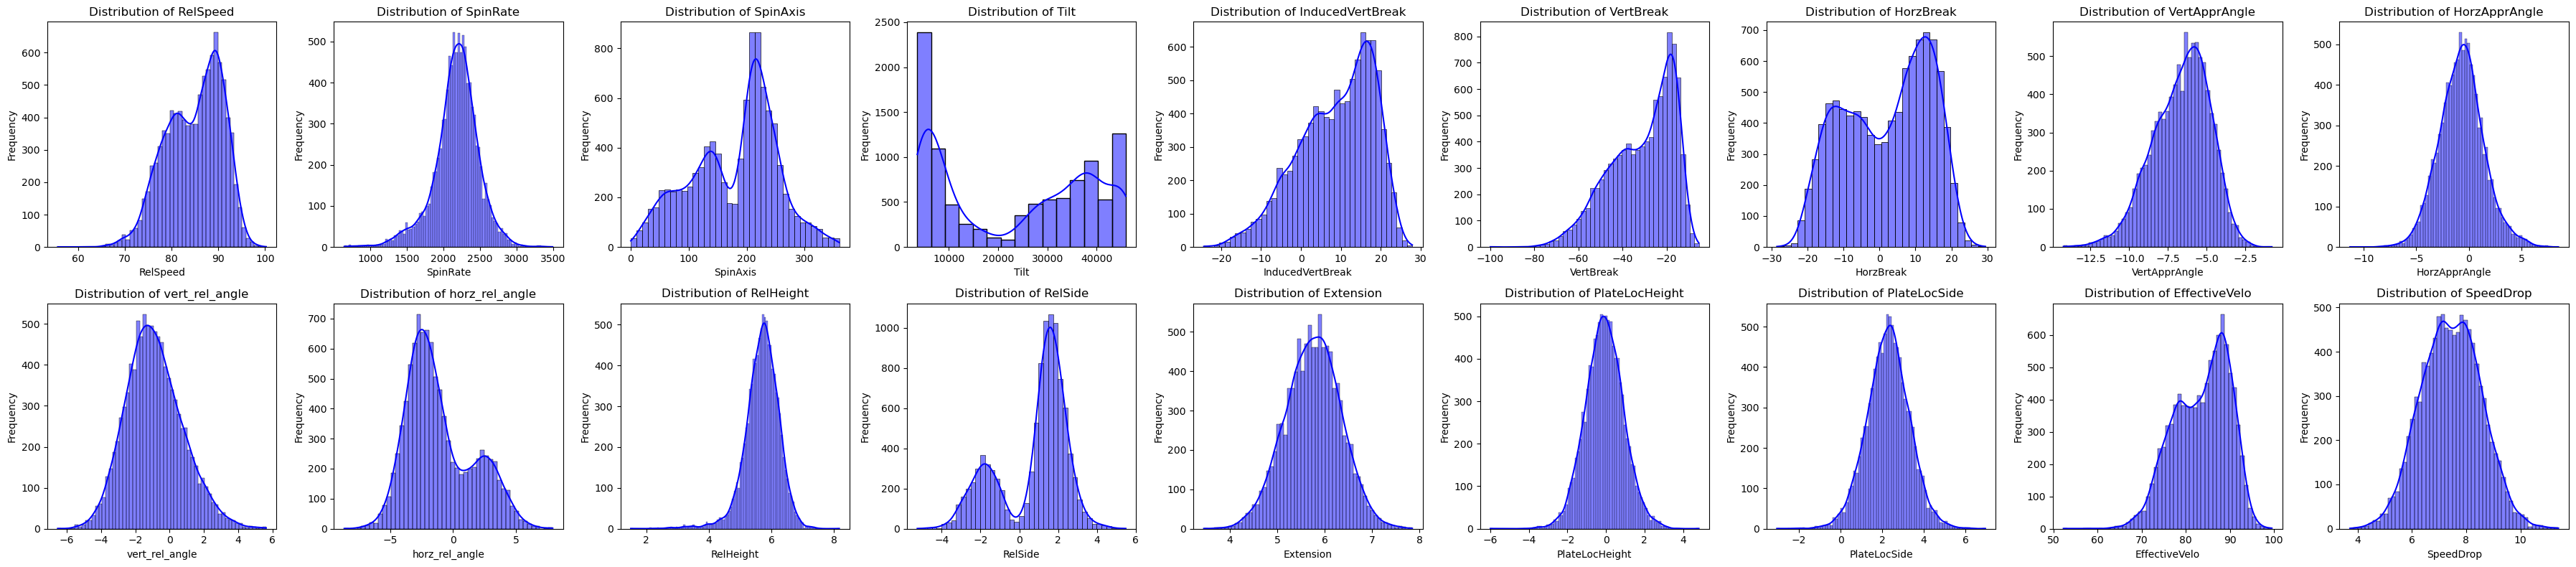

  0%|          | 0/30 [00:00<?, ?it/s]

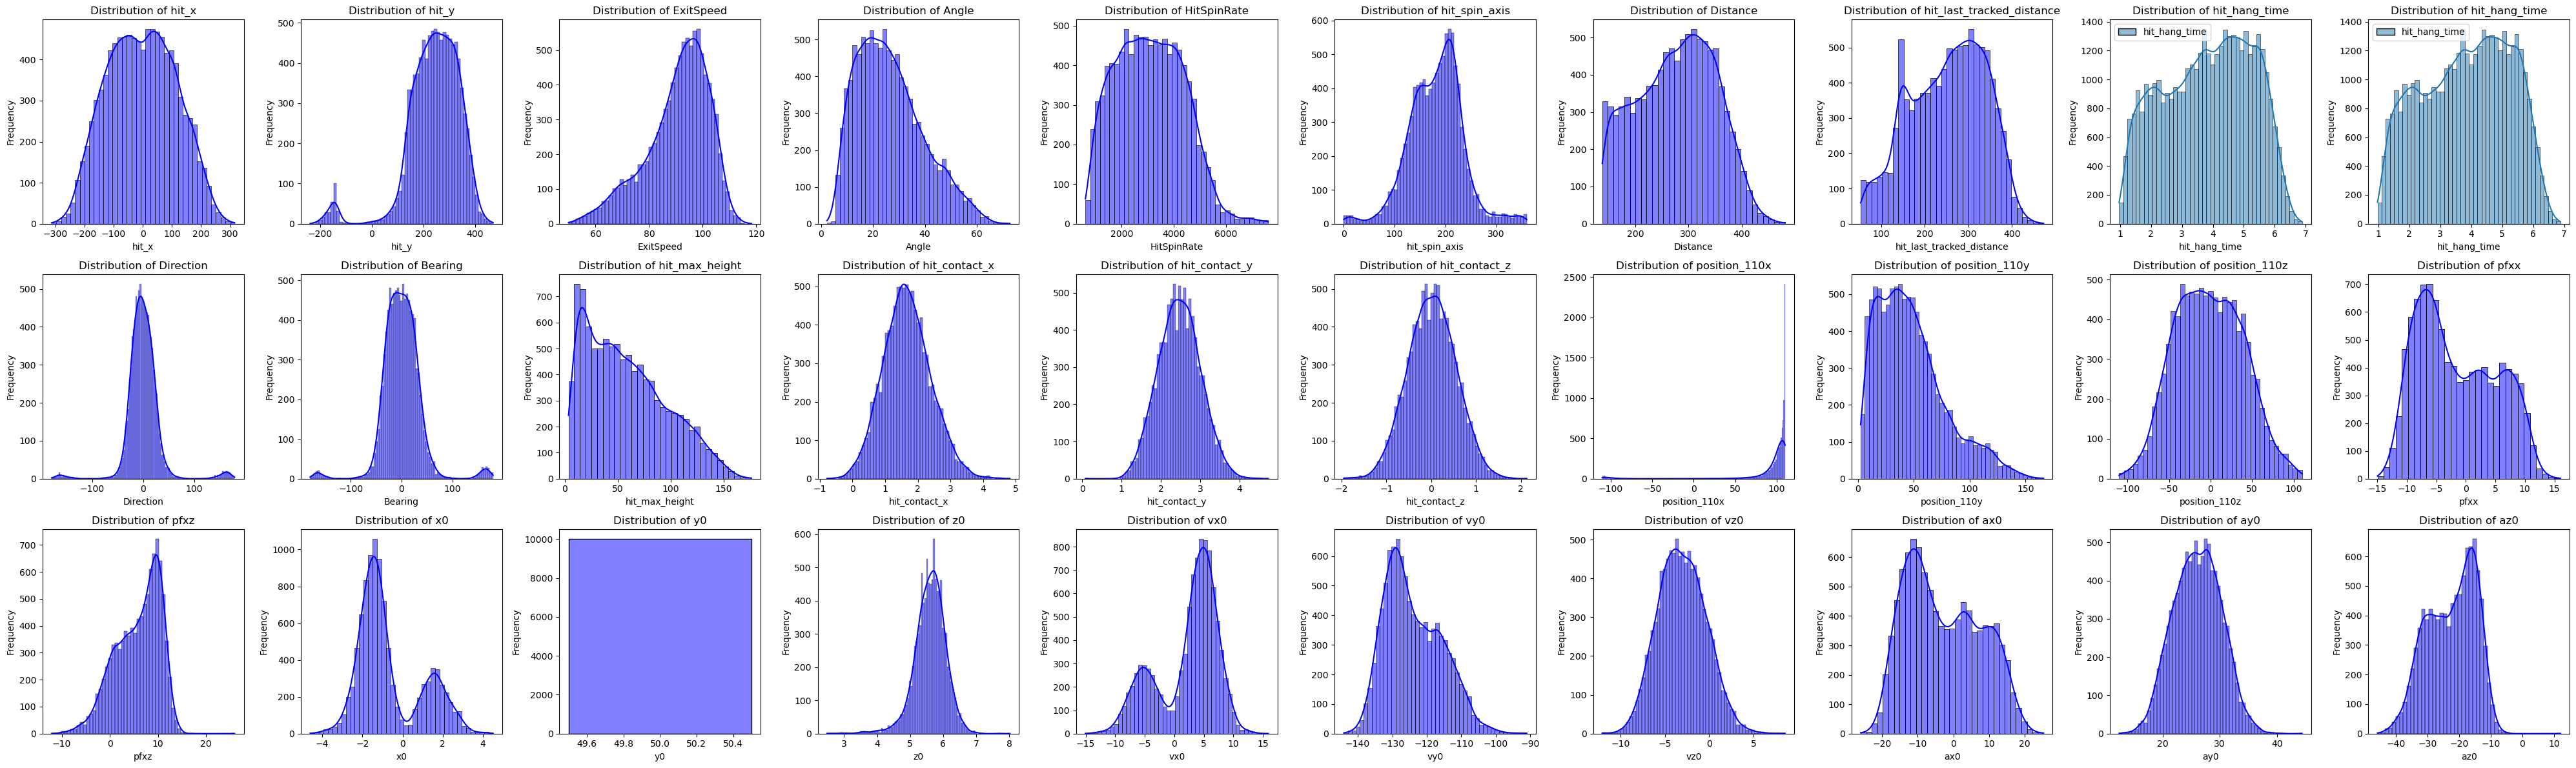

In [26]:
from tqdm.notebook import tqdm


pitch_features = [
    'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak',
    'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 'RelHeight', 
    'RelSide', 'Extension', 'PlateLocHeight', 'PlateLocSide', 'EffectiveVelo', 'SpeedDrop'
]

hit_features = [
    'hit_x', 'hit_y', 'ExitSpeed', 'Angle', 'HitSpinRate', 'hit_spin_axis', 'Distance', 
    'hit_last_tracked_distance', 'hit_hang_time', 'hit_hang_time', 'Direction', 'Bearing',
    'hit_max_height', 'hit_contact_x', 'hit_contact_y', 'hit_contact_z', 'position_110x', 
    'position_110y', 'position_110z', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 
    'vy0', 'vz0', 'ax0', 'ay0', 'az0'
]


pitch_data = data[pitch_features]
cleaned_pitch_data = pitch_data.dropna()

hit_data = data[hit_features]
cleaned_hit_data = hit_data.dropna()

def graph_distributions(df: pd.DataFrame, n_cols=4, n_sample=10000, random_state=42):
    if n_sample:
        df = df.sample(n=n_sample, random_state=random_state)
    interactivity = InteractiveShell.ast_node_interactivity
    InteractiveShell.ast_node_interactivity = "none"

    n_rows = (len(df.columns) + n_cols - 1) // n_cols

    # Calculate the size of each subplot to make them square
    subplot_size = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_size * n_cols, subplot_size * n_rows))
    axes = axes.flatten()

    for i, feature in tqdm(enumerate(df.columns), total=len(df.columns)):
        sns.histplot(df[feature], kde=True, ax=axes[i], color="blue")
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    InteractiveShell.ast_node_interactivity = interactivity

    plt.tight_layout()
    plt.show()

graph_distributions(cleaned_pitch_data, n_cols=9)
graph_distributions(cleaned_hit_data, n_cols=10)

### Feature Engineering

Now we get to feature engineering. There are some notable categorical features that we want to one-hot encode or turn into binary variables, to allow convenient modeling. These operations are shown below.


In [44]:
from sklearn.preprocessing import OrdinalEncoder

numerical = [
    "PitcherThrows",
    "PitcherTeam",
    "BatterSide",
    "BatterTeam",
    "TaggedPitchType",
    "inning_half"
]

# Make the handed-ness and Teams a boolean value
data["PitcherThrows"] = data["PitcherThrows"].map({"L":0, "R":1})
data["PitcherTeam"] = (data["PitcherTeam"] == "TEX_LON").astype(int)
data["BatterSide"] = data["BatterSide"].map({"L":0, "R":1})
data["BatterTeam"] = (data["BatterTeam"] == "TEX_LON").astype(int)
data["inning_half"]

# We also want to engineer this new feature indicating the
# handed-ness matchup. Statistically, L/L or R/R favors the pitcher
# while L/R or R/L favors the batter. We want to represent this as 
# a new feature!
data["Sidematchup"] = (data["PitcherThrows"] == data["BatterSide"]).astype(int)




0           Top
1           Top
6        Bottom
10       Bottom
15       Bottom
          ...  
10179       Top
10183       Top
10209       Top
10219    Bottom
10229    Bottom
Name: inning_half, Length: 1570, dtype: object

In [34]:
# Remove the Knuckleball and Four-seam
knuckle_four_rows = after_hit_data[after_hit_data["TaggedPitchType"].isin(["Knuckleball", "Four-Seam"])].index
after_hit_data = after_hit_data.drop(knuckle_four_rows)

# Encode the TaggedPitchType Ordinally
encoder = OrdinalEncoder()
after_hit_data["TaggedPitchTypeOrdinal"] = encoder.fit_transform(after_hit_data[["TaggedPitchType"]])
pd.DataFrame(after_hit_data[["TaggedPitchType", "TaggedPitchTypeOrdinal"]])

,TaggedPitchType,TaggedPitchTypeOrdinal
0,Fastball,3.0
1,Fastball,3.0
6,Curveball,1.0
10,Slider,5.0
15,ChangeUp,0.0
...,...,...
10179,Fastball,3.0
10183,Slider,5.0
10209,Splitter,6.0
10219,Sinker,4.0


## Modeling

### Decision Trees (Cristian)

In [35]:
pd.DataFrame(data.isnull().sum())
data = data.drop_duplicates()

,0
PitchNo,0
Inning,0
inning_half,0
PAofInning,0
PitchofPA,0
PitcherThrows,0
PitcherTeam,0
BatterSide,0
BatterTeam,0
Balls,0


Now lets deal with null values. Here we will remove columns with too many nulls and replace the remaining nulls with their average. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# dropping the position columns because over 800 are null for position
# and over 500 are null for HitSpinRate
position_columns = ['position_110x', 'position_110y', 'position_110z', 'HitSpinRate']
# data = data.drop(columns=position_columns)

# Columns with 2 null values
columns_with_2_nulls = [
    'RelSpeed', 'SpinRate', 'SpinAxis', 'Tilt', 'InducedVertBreak', 'VertBreak', 
    'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'vert_rel_angle', 'horz_rel_angle', 
    'RelHeight', 'RelSide', 'PlateLocHeight', 'PlateLocSide', 'zone_time', 
    'EffectiveVelo', 'SpeedDrop', 'pfxx', 'pfxz', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 
    'ax0', 'ay0', 'az0'
]

# Identify rows with null values in these columns
rows_with_nulls = data[columns_with_2_nulls].isnull().any(axis=1)

# Check if these rows are the same across all columns
common_null_rows = data[rows_with_nulls].index

# If all rows are the same, remove them
if len(common_null_rows) == 2:
    data = data.drop(index=common_null_rows)

# Separate numerical and non-numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values for numerical columns with the mean
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

# Fill missing values for non-numerical columns with the mode
for column in non_numerical_columns:
    data[column] = data[column].fillna(data[column].mode()[0])

# Verify the changes
print("Shape:", data.shape)
pd.DataFrame(data.isnull().sum()).transpose()

# One-hot encode non-numerical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
encoded_features = encoder.fit_transform(data[non_numerical_columns])
encoded_feature_names = encoder.get_feature_names_out(non_numerical_columns)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)

# Concatenate the original numerical columns with the encoded features
data = pd.concat([data[numerical_columns], encoded_df], axis=1)

# Verify the changes
print("Shape:", data.shape)
data.head()

Empty DataFrame
Columns: [PitchNo, Inning, inning_half, PAofInning, PitchofPA, PitcherThrows, PitcherTeam, BatterSide, BatterTeam, Balls, Strikes, Outs, RelSpeed, SpinRate, SpinAxis, Tilt, InducedVertBreak, VertBreak, HorzBreak, VertApprAngle, HorzApprAngle, vert_rel_angle, horz_rel_angle, RelHeight, RelSide, Extension, PlateLocHeight, PlateLocSide, zone_time, EffectiveVelo, SpeedDrop, ExitSpeed, Angle, hit_spin_axis, hit_contact_x, hit_contact_y, hit_contact_z, pfxx, pfxz, x0, y0, z0, vx0, vy0, vz0, ax0, ay0, az0, IsHomeRun, Sidematchup]
Index: []

[0 rows x 50 columns]
PitchNo             0
Inning              0
inning_half         0
PAofInning          0
PitchofPA           0
PitcherThrows       0
PitcherTeam         0
BatterSide          0
BatterTeam          0
Balls               0
Strikes             0
Outs                0
RelSpeed            0
SpinRate            0
SpinAxis            0
Tilt                0
InducedVertBreak    0
VertBreak           0
HorzBreak           0
Vert

In [58]:
# Inspect the numerical columns
data = data.drop(columns=['PitchNo', 'y0'], errors='ignore')
pd.set_option('display.max_columns', None)
data.describe()

# # Determine which columns to round and to what precision
# # For example, let's round columns with large values to the nearest integer
# columns_to_round = ['ExitSpeed', 'Angle', 'HitSpinRate', 'hit_spin_axis', 'hit_contact_x', 'hit_contact_y', 'hit_contact_z']

# # Apply rounding
# data[columns_to_round] = data[columns_to_round].round(0)

# # Verify the changes
# print(data[columns_to_round].head())

            Inning   PAofInning    PitchofPA  PitcherThrows   BatterSide  \
count  1568.000000  1568.000000  1568.000000    1568.000000  1568.000000   
mean      4.867347     2.940051     3.397321       0.723852     0.549745   
std       2.537329     1.758263     1.845581       0.447234     0.497678   
min       1.000000     1.000000     1.000000       0.000000     0.000000   
25%       3.000000     2.000000     2.000000       0.000000     0.000000   
50%       5.000000     3.000000     3.000000       1.000000     1.000000   
75%       7.000000     4.000000     5.000000       1.000000     1.000000   
max      11.000000    12.000000    12.000000       1.000000     1.000000   

             Balls      Strikes         Outs     RelSpeed     SpinRate  \
count  1568.000000  1568.000000  1568.000000  1568.000000  1568.000000   
mean      1.122449     1.074617     0.985969    86.883316  2185.542895   
std       1.016924     0.813993     0.814550     5.076175   294.868696   
min       0.000000 

### Neural Nets ()

### SVM

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Remove the target variable 'IsHomeRun' from features (X) and store it separately (y)
X = data.drop('IsHomeRun', axis=1)
y = data['IsHomeRun']

# Split to get the training and the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Scale the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Since there is more non-homeruns than homeruns we need to use SMOTE to create a balanced training dataset
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Train and predict for the SVM model
print("Training SVM model...")
svm_model = SVC()
svm_model.fit(X_train_balanced, y_train_balanced)
svm_pred = svm_model.predict(X_test_scaled)

#Create and display results for classification report and confusion matrix
print("\nSVM Model Results:")
print("-----------------")
print(classification_report(y_test, svm_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, svm_pred))

Training SVM model...

SVM Model Results:
-----------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       373
           1       0.60      0.32      0.41        19

    accuracy                           0.96       392
   macro avg       0.78      0.65      0.70       392
weighted avg       0.95      0.96      0.95       392


Confusion Matrix:
[[369   4]
 [ 13   6]]


Through multiple iterations we can see a some consistencies in the results shown. For 1, the model can accurately predict when the play isn't a home-run with over a 90% success rate. For accurately predicting a home-run the model has ranges with at most having a 60% rate and the least being a 35% rate of success.

Training Random Forest model...


<Axes: xlabel='importance', ylabel='feature'>

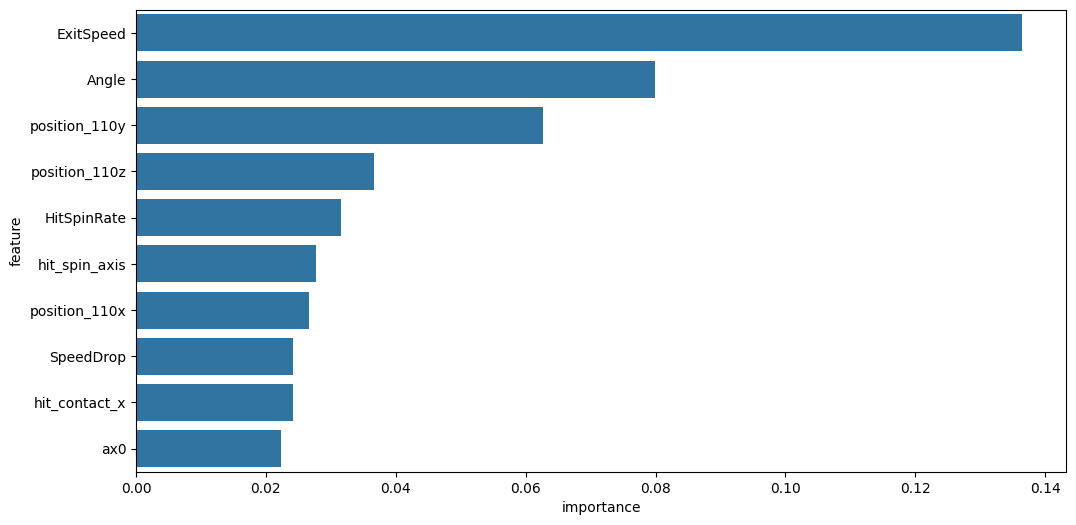

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Finding which features are the most important in determining a home-run
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plotting the ten most important features in the dataset for determining a home-run
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10),x='Importance',y='Feature')

When looking at the data, we can see that the results are actually relevant to what we know about baseball. For example, numbers like the ExitSpeed (speed of ball after being hit) and Angle (when hit) are important because they give a great indication of when a ball has enough power/height to make it past the field and into the stands.

### Naive Bayes

Usually Naive Bayes is used for categorical features, however we can make it work with continuous data through binning. First we will start by reading in the data.

In [28]:
data = pd.read_csv('data.csv')
pd.set_option('display.max_columns', None)

data.head()

Here we can see that the PlayResult label has inconsistent casing so we will convert it all to lowercase before transforming it

In [67]:
data['PlayResult'].unique()

labels = (data['PlayResult'].str.lower())

labels.unique()

y = (labels == 'homerun').astype(int)
y.unique()

array(['Undefined', 'Strikeout', 'Single', 'FieldersChoice', 'Out',
       'Double', 'Walk', 'Sacrifice', 'HomeRun', 'Error', 'Triple',
       'StolenBase', 'CaughtStealing', 'error', 'SIngle', 'homerun'],
      dtype=object)

array(['undefined', 'strikeout', 'single', 'fielderschoice', 'out',
       'double', 'walk', 'sacrifice', 'homerun', 'error', 'triple',
       'stolenbase', 'caughtstealing'], dtype=object)

array([0, 1])

## Outcome